# <center> Assignment 2 - Computer Vision ENCS5343


### This assignment achieve to implement Content-Based Image Retrieval (CBIR) using various image representations in order to compare between them, observe the results of each method, measure the efficiency of each method using metrics (Precision, Recall, AUC, F1-Score, ....)
#### Steps: 
1. Data processing (uploading images and getting them ready).
2. Choose an image representation technique.
3. Apply the CBIR on 15 different queries and measure the preformace using different measure metrics.
4. Observe the results depending with their rankings.
5. Compare between the techniques.

### Step 0: Import important packages and libraries.

In [24]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
import time
from sklearn.metrics import auc, roc_curve
from scipy.stats import kurtosis, mode

### Step 1: Upload and store the data.

In [2]:
def upload_and_store_images(dataset_filepath):
    images = []
    for filename in sorted(os.listdir(path=dataset_filepath)):
        image_path = os.path.join(dataset_filepath, filename)
        if os.path.isfile(image_path):
            try: 
                images.append(Image.open(image_path))
            except:
                print("Failed to upload image: {image_path}")
    return images
images = upload_and_store_images('./dataset')

### Step 2: Choose an image representation technique.

#### A. Color Histogram

In [3]:
def calculate_color_histogram(images, number_of_bins):
    color = ('b', 'g', 'r')
    histograms = []
    for i in range(len(images)):
        histograms.append([])
        total_pixels = images[i].height * images[i].width
        img = np.array(images[i])[:, :, ::-1].copy()
        for i in range(len(color)):
            histograms[-1].append(cv.calcHist([img], [i], None, [number_of_bins], [0,256]) / total_pixels)
    return np.array(histograms)

#### Step 3 for Color Histogram: Apply CBIR on different random 15 query images

In [4]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
def distance_to_probability(distance):
    return np.exp(-distance)

def calculate_probabilities(index_query_image, images, features):
    probabilities = []
    for i, image in enumerate(images):
        distance = np.linalg.norm(features[index_query_image] - features[i])
        probabilities.append([image, distance_to_probability(distance), classes[i // 100]])
    probabilities.sort(key=lambda x: x[1], reverse=True)
    return probabilities


In [6]:
def retrieve_similar_images_using_hist(images, bins, threshold):
    global classes
    query_images_idxs = []
    query_images_classes = []
    query_images_similar_images = []
    query_images_similar_images_classes = []
    query_images_similar_images_probabilities = []
    for i in range(15):
        random_idx = np.random.randint(0, 1000)
        query_images_idxs.append(random_idx)
        query_images_classes.append(classes[random_idx // 100])
        probabilities = calculate_probabilities(random_idx, images, features=calculate_color_histogram(images, bins))
        query_images_similar_images.append([probability[0] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_probabilities.append([probability[1] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_classes.append([probability[2] for probability in probabilities if probability[1] >= threshold])
    return query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities

def compute_measures(query_image_class, retrieved_images_classes):
    true_positives = sum([1 for retrieved_image_class in retrieved_images_classes if retrieved_image_class == query_image_class])
    false_positives =  len(retrieved_images_classes) - true_positives
    false_negatives = 100 - true_positives
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 / ((1 / recall) + (1 / precision)) if (recall + precision) > 0 else 0
    return f1_score, precision, recall



In [7]:
def show_results(function_tuple):
    
    query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities = function_tuple
    f1_score = 0
    recall = 0
    precision = 0 
    true_labels = []
    predicted_probs = []
    for i in range(len(query_images_idxs)):
        f1_score_i, precision_i, recall_i = compute_measures(query_images_classes[i], query_images_similar_images_classes[i])
        f1_score += f1_score_i
        recall += recall_i
        precision += precision_i
        true_labels += [1 if label == query_images_classes[i] else 0 for label in query_images_similar_images_classes[i]]
        predicted_probs += query_images_similar_images_probabilities[i]

   
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    auc_measure = auc(fpr, tpr)
    print(f"F1-score: {f1_score / 15}")
    print(f"Recall score: {recall / 15}")
    print(f"Precision score: {precision / 15}")
    print(f"AUC: {auc_measure}")
    
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    query_image = images[query_images_idxs[0]]
    plt.figure(figsize=(20, 20))
    for i, image in enumerate([query_image] + query_images_similar_images[0][:9]):
        plt.subplot(1, 10, 1 + i)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

For 120 bins: 

Time elapsed: 13.205986976623535
F1-score: 0.16155367559770575
Recall score: 0.46199999999999997
Precision score: 0.3647852931486834
AUC: 0.5175837364185663


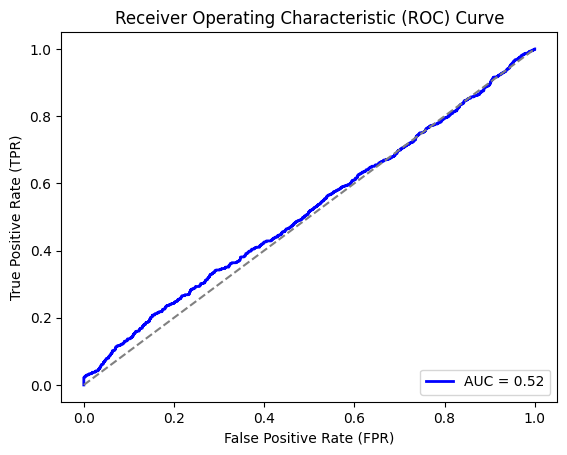

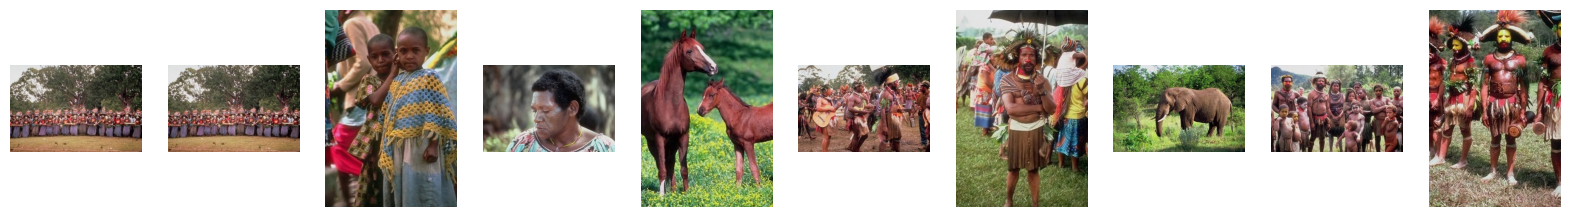

In [8]:
print("For 120 bins: \n")
start_time = time.time()
function_tuple = retrieve_similar_images_using_hist(images=images, bins=120, threshold=0.8)
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

For 180 bins: 

Time elapsed: 11.814512968063354
F1-score: 0.18778591449266582
Recall score: 0.6366666666666666
Precision score: 0.1737159968538276
AUC: 0.5723779789809939


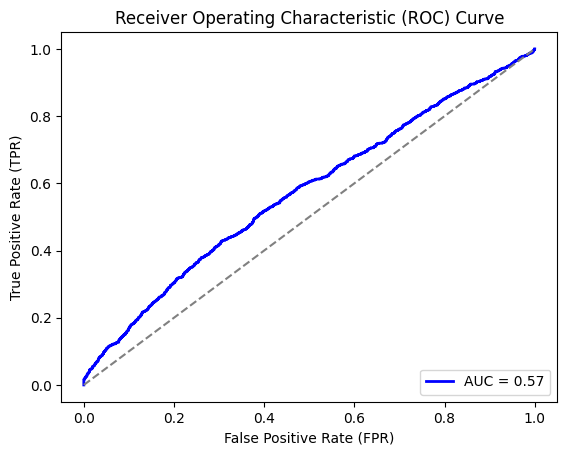

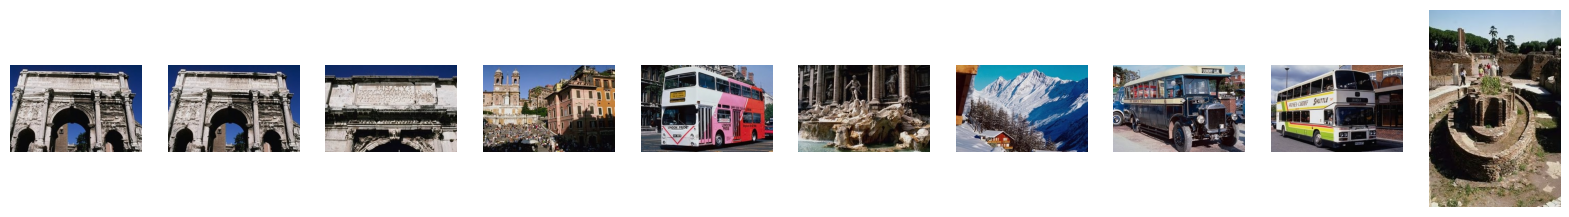

In [9]:
print("For 180 bins: \n")
start_time = time.time()
function_tuple = retrieve_similar_images_using_hist(images=images, bins=180, threshold=0.8)
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

For 360 bins: 

Time elapsed: 11.95552396774292
F1-score: 0.14275547479414985
Recall score: 0.5473333333333333
Precision score: 0.2831558088647167
AUC: 0.5348472923460768


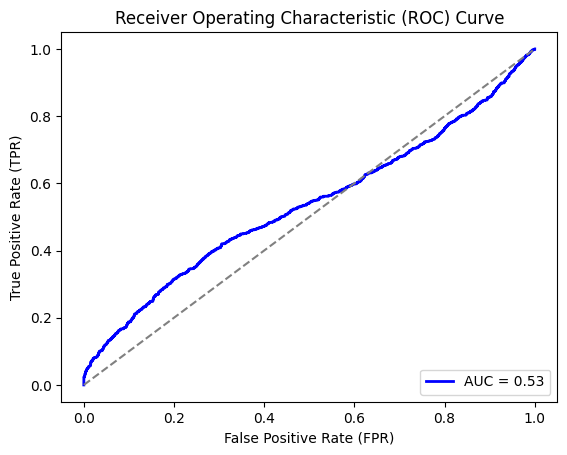

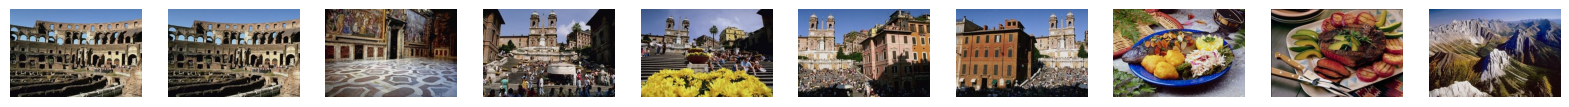

In [11]:
print("For 360 bins: \n")
start_time = time.time()
function_tuple = retrieve_similar_images_using_hist(images=images, bins=360, threshold=0.8)
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)


#### B. Color moments

In [25]:
def calculate_moments(images, six_features,weights):
    global classes
    features = []
    for i in range(len(images)):
        features.append([])
        for j in range(3):
            image_np = np.array(images[i])[:, :, ::-1].copy()
            data = image_np[:, :, j]
            mean = np.mean(data)
            std = np.std(data)
            skewness = np.mean((data - mean) ** 3) / (std ** 3) if std != 0 else 0
            if six_features == True:
                median = np.median(data)
                kurtosis_measure = kurtosis(data, axis=None)
                mode_measure = mode(np.concatenate(data)).mode
                features[-1].append([mean * weights[0],std * weights[1], skewness * weights[2], mode_measure * weights[3], median * weights[4], kurtosis_measure * weights[5]])
            else:
                features[-1].append([weights[0] * mean, weights[1] * std, skewness * weights[2]])
    return np.array(features)


def retrieve_similar_images_using_moments(images, six_features, weights, threshold=0.1):
    global classes
    query_images_idxs = []
    query_images_classes = []
    query_images_similar_images = []
    query_images_similar_images_classes = []
    query_images_similar_images_probabilities = []
    for i in range(15):
        random_idx = np.random.randint(0, 1000)
        query_images_idxs.append(random_idx)
        query_images_classes.append(classes[random_idx // 100])
        probabilities = calculate_probabilities(random_idx, images, features=calculate_moments(images, weights=weights, six_features=six_features))
        query_images_similar_images.append([probability[0] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_probabilities.append([probability[1] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_classes.append([probability[2] for probability in probabilities if probability[1] >= threshold])
    return query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities

For 3 unweighted features: 

Time elapsed: 119.29715967178345
F1-score: 0.019801980198019802
Recall score: 0.01
Precision score: 1.0
AUC: nan


/home/diaeddintahboub/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


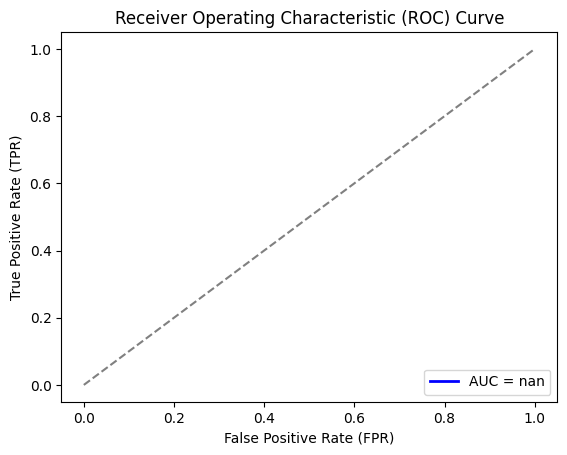

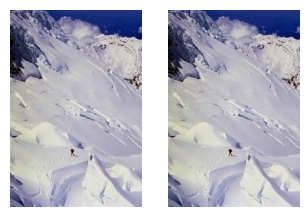

In [27]:
print("For 3 unweighted features: \n")
start_time = time.time()
function_tuple = retrieve_similar_images_using_moments(images=images, threshold=0.01, weights=[1, 1, 1], six_features=False)
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)


For 3 weighted features: 

Time elapsed: 117.46541476249695
F1-score: 0.04452128280547321
Recall score: 0.024666666666666674
Precision score: 0.44307772340381035
AUC: 0.6566837107377648


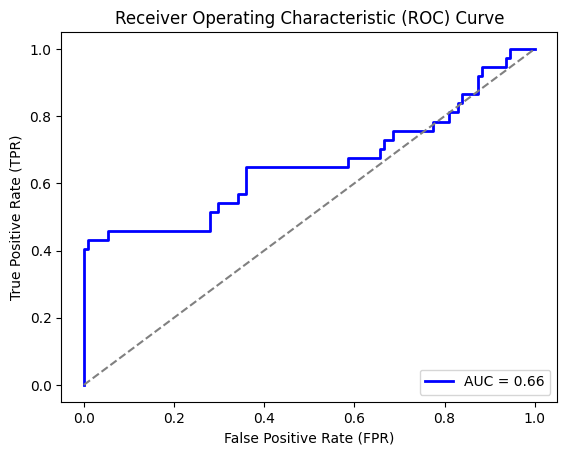

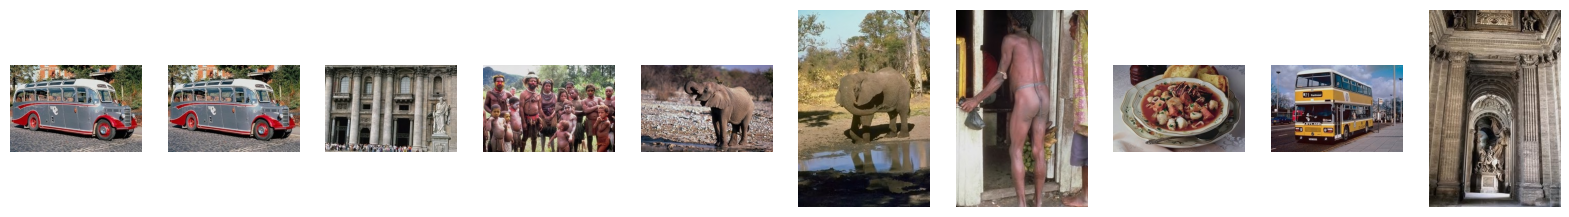

In [21]:
print("For 3 weighted features: \n")
start_time = time.time()
function_tuple = retrieve_similar_images_using_moments(images=images, threshold=0.01, weights=[0.25, 0.35, 0.4], six_features=False)
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

For 6 weighted features: 

Time elapsed: 281.3612689971924
F1-score: 0.026333472305764816
Recall score: 0.014000000000000002
Precision score: 0.9515151515151515
AUC: 0.8333333333333335


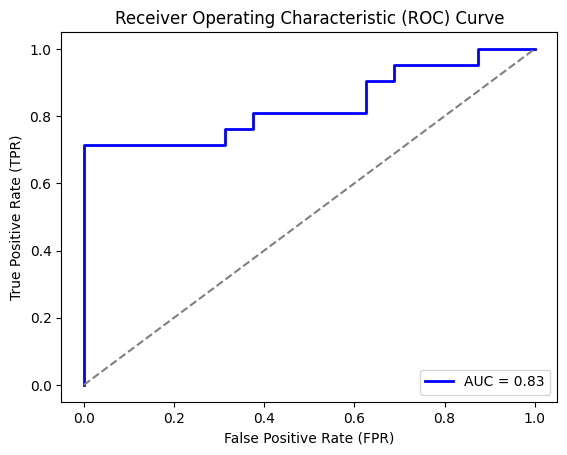

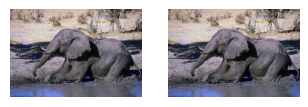

In [26]:
print("For 6 weighted features: \n")
start_time = time.time()
function_tuple = retrieve_similar_images_using_moments(images=images, threshold=0.01, weights=[0.25, 0.35, 0.4, 0.5, 0.55, 0.6], six_features=True)
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)